<a href="https://colab.research.google.com/github/DavMLPath/PhD-Theses/blob/main/Banking_Stability_Modeling_SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

from statistics import mean
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from datetime import date, timedelta

# **Loading data from drive, doing feature selection/transformation**

In [2]:
#importing libs for the model
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
x=pd.read_excel('/content/drive/My Drive/Dissertation/Data/factors_all_final.xlsx', sheet_name='Factors')
y=pd.read_excel('/content/drive/My Drive/Dissertation/Data/factors_all_final.xlsx', sheet_name='Z-score(Y)')

In [4]:
x

,Date,Inflow (trade),Inflow (non-trade),Outflow (trade),Outflow (non-trade),Reserve position in the IMF,Foreign Exchange Reserves,Medium term government bond yield,Government bond yield (<365 days),Government’s net domestic assets (million AMD),...,Industry Loans (fc),Agriculture loans (fc),Construction loans (fc),Transport and communications loans (fc),Trade loans (fc),Service sector loans (fc),Consumer loans loans (fc),Mortgage loans (fc),Others loans (fc),bitcoin_price
0,2012-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,306998.000000,60928.000000,83506.000000,33020.000000,245827.000000,64936.000000,50669.000000,63059.000000,68917.000000,NaN
1,2013-01-01,11826.68,33862.69,15899.23,8403.41,31.817898,1736.221600,14.830000,9.840550,-130755.122057,...,313322.077605,61350.991508,84211.842501,32666.773688,244769.972006,64307.324495,51457.023801,62998.863526,71844.455445,15.000000
2,2013-02-01,19159.65,42073.32,17465.09,9732.57,21.638079,1749.943371,14.220000,9.524625,-121970.413340,...,319903.974531,63763.779875,84390.089111,33228.338577,254714.082293,68132.675487,51144.382278,64452.406933,74395.603897,25.000000
3,2013-03-01,15961.90,49238.91,15587.23,10644.96,1.650734,1629.567187,15.280000,9.224075,-104492.779251,...,265890.171536,65987.990468,87762.135535,34462.765862,267116.626975,72061.709593,54817.173974,67016.688425,75832.846228,60.000000
4,2013-04-01,21076.73,54667.24,17350.24,12087.77,13.734087,1624.451359,14.170000,9.132075,-105017.910906,...,271201.719822,66225.913770,86847.513199,34124.331103,257391.481342,72191.492730,54991.754943,66225.477979,75451.773699,139.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,2024-08-01,178606.77,35408.98,188038.20,13497.13,13.475149,3590.834512,9.890100,8.717050,-486586.921729,...,319341.846107,66128.195684,336681.882481,79547.616541,342338.844085,229127.496582,100853.406631,107339.750203,123999.045078,58969.898366
141,2024-09-01,121777.07,33887.28,105735.66,12262.10,9.227394,3564.163126,9.927400,9.047600,-502688.648150,...,320104.747290,65883.177853,346686.267154,86648.138076,353214.939536,226932.315598,102953.448968,106398.802299,159417.290219,63329.498129
142,2024-10-01,182677.68,32947.73,138814.18,14827.91,9.081365,3581.478738,9.860100,8.769651,-439828.621106,...,323923.714290,65036.707799,355395.003785,101658.323747,360852.410845,221614.772564,100076.733070,107049.322115,162163.374306,70215.185633
143,2024-11-01,146812.19,31069.27,132209.79,15510.02,12.881199,3520.320960,9.888000,8.728722,-467697.097676,...,335665.010871,82376.609751,364763.881423,99060.391607,377609.270103,221815.201932,100023.646291,109743.450574,169403.795748,96449.055813


In [5]:
#here if we need to exclude multicolinearity, we need to transform the data using the following order:
#1)make series stationary
#2)add lagged features
#3)standardize
#4)use ridge/lasso to filter

In [6]:
#independent variables

#x=pd.read_excel('/content/drive/My Drive/Dissertation/Data/factors_all.xlsx', sheet_name='Sheet1')
x.index=x['Date']
x
x=x.drop(columns=['Date'])
# print(len(x.columns.values))
# print((x.columns.values))

In [7]:
x

,Inflow (trade),Inflow (non-trade),Outflow (trade),Outflow (non-trade),Reserve position in the IMF,Foreign Exchange Reserves,Medium term government bond yield,Government bond yield (<365 days),Government’s net domestic assets (million AMD),Banks’ net domestic assets (million AMD),...,Industry Loans (fc),Agriculture loans (fc),Construction loans (fc),Transport and communications loans (fc),Trade loans (fc),Service sector loans (fc),Consumer loans loans (fc),Mortgage loans (fc),Others loans (fc),bitcoin_price
Date,,,,,,,,,,,,,,,,,,,,,
2012-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,306998.000000,60928.000000,83506.000000,33020.000000,245827.000000,64936.000000,50669.000000,63059.000000,68917.000000,NaN
2013-01-01,11826.68,33862.69,15899.23,8403.41,31.817898,1736.221600,14.830000,9.840550,-130755.122057,175166.317124,...,313322.077605,61350.991508,84211.842501,32666.773688,244769.972006,64307.324495,51457.023801,62998.863526,71844.455445,15.000000
2013-02-01,19159.65,42073.32,17465.09,9732.57,21.638079,1749.943371,14.220000,9.524625,-121970.413340,168021.373038,...,319903.974531,63763.779875,84390.089111,33228.338577,254714.082293,68132.675487,51144.382278,64452.406933,74395.603897,25.000000
2013-03-01,15961.90,49238.91,15587.23,10644.96,1.650734,1629.567187,15.280000,9.224075,-104492.779251,153064.570012,...,265890.171536,65987.990468,87762.135535,34462.765862,267116.626975,72061.709593,54817.173974,67016.688425,75832.846228,60.000000
2013-04-01,21076.73,54667.24,17350.24,12087.77,13.734087,1624.451359,14.170000,9.132075,-105017.910906,187425.309436,...,271201.719822,66225.913770,86847.513199,34124.331103,257391.481342,72191.492730,54991.754943,66225.477979,75451.773699,139.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,178606.77,35408.98,188038.20,13497.13,13.475149,3590.834512,9.890100,8.717050,-486586.921729,741348.175181,...,319341.846107,66128.195684,336681.882481,79547.616541,342338.844085,229127.496582,100853.406631,107339.750203,123999.045078,58969.898366
2024-09-01,121777.07,33887.28,105735.66,12262.10,9.227394,3564.163126,9.927400,9.047600,-502688.648150,914168.220329,...,320104.747290,65883.177853,346686.267154,86648.138076,353214.939536,226932.315598,102953.448968,106398.802299,159417.290219,63329.498129
2024-10-01,182677.68,32947.73,138814.18,14827.91,9.081365,3581.478738,9.860100,8.769651,-439828.621106,677416.914478,...,323923.714290,65036.707799,355395.003785,101658.323747,360852.410845,221614.772564,100076.733070,107049.322115,162163.374306,70215.185633


In [8]:
#dependent variable

y=pd.read_excel('/content/drive/My Drive/Dissertation/Data/factors_all_final.xlsx', sheet_name='Z-score(Y)')
y.index=y['Date']
y.drop(columns=['Date'], inplace=True)

In [9]:
y

,Z-score
Date,
2013-01-01,7.521965
2013-02-01,7.951818
2013-03-01,7.337288
2013-04-01,5.987805
2013-05-01,8.550364
...,...
2024-08-01,7.824952
2024-09-01,8.755918
2024-10-01,6.504123


In [10]:
dep_var=y['Z-score']

In [11]:
x['Mortgage loans']=np.log(x['Mortgage loans'])

##List of factors with growth rate

In [12]:

#ROA+(equity/assets))/sd(ROA)

to_change=[
'Industry Loans'
,'Demand deposits in AMD (million AMD)'
,'Time deposits in AMD (million AMD)'
,'Foreign currency deposits (million AMD)'
,'Inv. comp. Sales and purchase transactions (million AMD)'
,'Construction loans'
,'Agriculture loans'
#,'Accumulated profit (million AMD)'
,'Total capital (million AMD)'
,'Consumer loans loans'
#,'Repo agreements (million AMD)'
,'Mortgage loans'
,'Trade loans'
,'Total liabilities (million AMD)'
,'High liquidity assets ratio to demand liabilities'
,'Russian Ruble/AMD'
,'Euro/AMD'
,'US Dollar/AMD'
,'Normative capital ratio to risk-weighted assets'
,'High liquidity assets ratio to total assets'
,'CPI'
]

for i in to_change:
  x[i]=x[i].pct_change()


In [13]:
x.columns.values

array(['Inflow (trade)', 'Inflow (non-trade)', 'Outflow (trade)',
       'Outflow (non-trade)', 'Reserve position in the IMF',
       'Foreign Exchange Reserves', 'Medium term government bond yield',
       'Government bond yield (<365 days)',
       'Government’s net domestic assets (million AMD)',
       'Banks’ net domestic assets (million AMD)',
       'Net other assets (million AMD)', 'CPI',
       'CPI-Consumer goods (including alcoholic beverages and tobacco)',
       'CPI-Non-consumer goods', 'CPI-Services',
       'Economic activity index',
       'Inv. comp. Sales and purchase transactions (million AMD)',
       'Inv. comp. Repo transactions (million AMD)',
       'Normative capital ratio to risk-weighted assets',
       'Tier 1 capital ratio to risk-weighted assets',
       'Non-performing loans ratio to total loans', 'Return on assets',
       'Return on capital', 'High liquidity assets ratio to total assets',
       'High liquidity assets ratio to demand liabilities',
    

##Definin factors to remove/combine


In [14]:
x['Dolarisation_avg']=(x['D1']+x['D2']+x['D3']+x['D5']+x['D4'])/4
x['Gov. bond yealds']=(x['Medium term government bond yield']+x['Government bond yield (<365 days)'])/2
x['fc-loans']=x["Industry Loans (fc)"]+x["Agriculture loans (fc)"]+x["Construction loans (fc)"]+x["Trade loans (fc)"]+x["Service sector loans (fc)"]+x["Consumer loans loans (fc)"]+x["Others loans (fc)"]
x.drop(columns=['Repo agreements (million AMD)','Accumulated profit (million AMD)','Total assets (million AMD)','Return on assets','Industry Loans (fc)', 'Agriculture loans (fc)', 'Construction loans (fc)', 'Trade loans (fc)', 'Service sector loans (fc)', 'Consumer loans loans (fc)', 'Others loans (fc)', 'D1', 'D2', 'D3', 'D4', 'D5','Medium term government bond yield','Government bond yield (<365 days)'], inplace=True)
x.drop(columns=['British Pound Sterling/AMD', 'Iranian Rial/AMD','Tier 1 capital ratio to risk-weighted assets','CPI-Consumer goods (including alcoholic beverages and tobacco)','CPI-Non-consumer goods','Swiss Franc/AMD', 'Georgian Lari/AMD'], inplace=True)

x['Dolarisation_avg']=x['Dolarisation_avg'].pct_change()
x.drop('2012-12-01', inplace=True)

In [15]:
#then we dif those factors to make them in the same level. we scale only x, without date

## **Stationarity adjustments**


In [16]:
#

In [17]:
#function for checking stationarity and returinig stationarized series
def check_stationarity(series):
  for i in range(0, 50):
      if i==0:
        dep_var = series
      else:
        dep_var= series - series.shift(i).fillna(0)
      result = adfuller(dep_var)
      adf_statistic = result[0]
      p_value = result[1]
      if float(("%.17f" % p_value).rstrip('0').rstrip('.'))<=0.05:
        break
  return i,("%.17f" % p_value).rstrip('0').rstrip('.'), dep_var
#      print("p-value:", ("%.17f" % p_value).rstrip('0').rstrip('.'))


In [18]:
# c=hip_df['growth'].dropna()
# check_stationarity(c)

In [19]:
y_o=y.copy()

In [20]:
y_o

,Z-score
Date,
2013-01-01,7.521965
2013-02-01,7.951818
2013-03-01,7.337288
2013-04-01,5.987805
2013-05-01,8.550364
...,...
2024-08-01,7.824952
2024-09-01,8.755918
2024-10-01,6.504123


In [21]:
# y_o=np.log(y_o)

In [22]:
# y

In [23]:
#choosing stationarity parameter for the dependent variable
a=check_stationarity(y['Z-score'])
y=a[2]
y

,Z-score
Date,
2013-01-01,7.521965
2013-02-01,0.429852
2013-03-01,-0.614530
2013-04-01,-1.349483
2013-05-01,2.562559
...,...
2024-08-01,0.994868
2024-09-01,0.930966
2024-10-01,-2.251795


In [24]:
#creating dictionary with stationarised variables
dict_normalized=pd.DataFrame()
stationarity=[]
features=[]
levels=[]
for i in x:
  if i not in ['Date', 'Բանկային տոկոս']:
    dict_normalized[i]=check_stationarity(x[i])[2]
#    print(check_stationarity(x[i])[0]   )
    stationarity.append([i, check_stationarity(x[i])[0]])
    features.append(i)
    levels.append(check_stationarity(x[i])[0])
dict_normalized

,Inflow (trade),Inflow (non-trade),Outflow (trade),Outflow (non-trade),Reserve position in the IMF,Foreign Exchange Reserves,Government’s net domestic assets (million AMD),Banks’ net domestic assets (million AMD),Net other assets (million AMD),CPI,...,Service sector loans,Consumer loans loans,Mortgage loans,Others loans,Transport and communications loans (fc),Mortgage loans (fc),bitcoin_price,Dolarisation_avg,Gov. bond yealds,fc-loans
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,11826.68,33862.69,15899.23,8403.41,31.817898,1736.221600,-130755.122057,175166.317124,191825.191936,0.007731,...,20598.408605,0.016509,-8.361170e-04,10917.020328,32666.773688,62998.863526,15.000000,0.013928,12.335275,891263.687361
2013-02-01,7332.97,8210.63,1565.86,1329.16,21.638079,13.721772,8784.708717,-7144.944087,11991.905376,-0.032008,...,-124.631052,0.007990,-3.522740e-05,443.378554,561.564889,64452.406933,25.000000,-0.021937,11.872312,25180.900111
2013-03-01,-3197.75,7165.59,-1877.86,912.39,1.650734,-120.376184,17477.634089,-14956.803026,-5716.027709,0.008236,...,-219.976200,0.040489,1.274980e-03,449.698689,1234.427285,67016.688425,60.000000,0.016117,-0.083237,-26975.933163
2013-04-01,5114.83,5428.33,1763.01,1442.81,13.734087,-5.115828,-525.131654,34360.739424,8304.680643,-0.005153,...,-152.219333,0.022991,3.834620e-04,-392.725488,-338.434759,66225.477979,139.000000,-0.017397,-0.221275,-5167.004804
2013-05-01,-6452.27,3755.59,1658.06,-1599.29,34.359215,10.891774,4855.041315,-4500.227729,8976.615989,0.000654,...,-583.160852,0.015826,-3.168855e-06,-302.921989,1830.300284,4955.669126,129.000000,0.015284,-1.102054,15844.272148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,24925.65,554.09,77912.11,-1556.86,13.475149,187.925419,2617.704885,27185.359100,-7652.661133,0.004633,...,1322.195612,0.023861,3.354004e-04,-1072.640564,1951.464976,-3781.283871,-12363.749560,0.012895,-0.028073,95920.264544
2024-09-01,-56829.70,-1521.70,-82302.54,-1235.03,9.227394,-26.671386,-16101.726421,172820.045148,-12042.863691,0.000839,...,3909.494825,0.025566,-4.624434e-07,3103.909994,7100.521535,-3605.958307,2692.641349,0.001082,0.138800,56721.469969
2024-10-01,60900.61,-939.55,33078.52,2565.81,9.081365,17.315612,62860.027044,-236751.305851,-1405.180998,0.001199,...,1592.963334,0.024482,4.086000e-04,1423.146486,15010.185672,-1479.566400,2725.573856,-0.012822,0.011300,13870.530043


##Calculating lagged values of time series:

In [25]:
denormdf=pd.DataFrame({"name":features, "diff_level":levels})

In [26]:
#variables, that are not stationary after 3-rd lag, we will exclude from model
s_list=pd.DataFrame(stationarity, columns=["factor", "level"])
valid_factors=s_list['factor'][s_list['level'].astype(float)<=7]
invalid_factors=s_list['factor'][s_list['level'].astype(float)>7]


In [27]:
invalid_factors

,factor


In [28]:
s_list[s_list['factor'].isin(invalid_factors)]

,factor,level


In [29]:
x=dict_normalized
x=x[valid_factors]


##Removing some factors with VIF

In [30]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Assuming X is your DataFrame of independent variables (exog)
X_v = x.copy()
X_v = x.dropna()  # Make sure there are no NaNs

# Add constant for intercept
from statsmodels.tools import add_constant
X_v_const = add_constant(X_v)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_v_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_v_const.values, i) for i in range(X_v_const.shape[1])]

#print(vif_data)
to_remove_vif=vif_data[vif_data['VIF']>5]
print(len(x.columns.values))
print(len(to_remove_vif))

44
6


In [31]:
to_remove_vif

,Feature,VIF
0,const,44775.324255
2,Inflow (non-trade),5.449941
6,Foreign Exchange Reserves,6.542840
29,Foreign debt,5.837621
43,Gov. bond yealds,5.699325
44,fc-loans,7.576591


In [32]:
x=x[[i for i in x.columns.values if i not  in to_remove_vif['Feature'].values]]

In [33]:
len(x.columns.values)

39

##Creating lagged factors for exog

In [34]:
#creating lags of the model
lag_1=x.shift(1)
lag_1_cols=[i+'_L1' for i in lag_1.columns.values]
lag_1.columns=lag_1_cols

lag_2=x.shift(2)
lag_2_cols=[i+'_L2' for i in lag_2.columns.values]
lag_2.columns=lag_2_cols


lag_3=x.shift(3)
lag_3_cols=[i+'_L3' for i in lag_3.columns.values]
lag_3.columns=lag_3_cols


lag_4=x.shift(4)
lag_4_cols=[i+'_L4' for i in lag_4.columns.values]
lag_4.columns=lag_4_cols


lag_5=x.shift(5)
lag_5_cols=[i+'_L5' for i in lag_5.columns.values]
lag_5.columns=lag_5_cols



lag_6=x.shift(6)
lag_6_cols=[i+'_L6' for i in lag_6.columns.values]
lag_6.columns=lag_6_cols

In [35]:
x_l=pd.concat([x,lag_1,lag_2, lag_3, lag_4, lag_5,lag_6],axis=1)
len(x_l.columns.values)

273

In [36]:
x_l.isnull().sum()

,0
Inflow (trade),0
Outflow (trade),0
Outflow (non-trade),0
Reserve position in the IMF,0
Government’s net domestic assets (million AMD),0
...,...
Others loans_L6,6
Transport and communications loans (fc)_L6,6
Mortgage loans (fc)_L6,6
bitcoin_price_L6,6


In [37]:
x_l.dropna(inplace=True)

##defining scaled features


In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(x_l)
scaled_features=pd.DataFrame(scaled_features, columns=x_l.columns.values)
scaled_features.index=x_l.index

In [39]:
import statsmodels.api as sm
x_ls=scaled_features


In [40]:
y=y.loc['2013-07-01':]

In [41]:
x_ls

,Inflow (trade),Outflow (trade),Outflow (non-trade),Reserve position in the IMF,Government’s net domestic assets (million AMD),Banks’ net domestic assets (million AMD),Net other assets (million AMD),CPI,CPI-Services,Economic activity index,...,Transport and communications loans_L6,Trade loans_L6,Service sector loans_L6,Consumer loans loans_L6,Mortgage loans_L6,Others loans_L6,Transport and communications loans (fc)_L6,Mortgage loans (fc)_L6,bitcoin_price_L6,Dolarisation_avg_L6
Date,,,,,,,,,,,,,,,,,,,,,
2013-07-01,0.055216,0.117652,0.151750,2.607223,-0.033031,0.363333,-0.078964,0.432947,7.615600,-0.527096,...,3.164761,-0.359227,7.988320,0.297851,-0.765215,1.671848,6.053955,4.770912,-0.224020,0.689693
2013-08-01,-0.303710,-0.055268,0.070037,2.214388,-0.272461,-0.016521,0.077441,-0.164397,3.772449,-0.334390,...,-0.122457,-0.044775,-0.355318,-0.174659,-0.044132,-0.038100,-0.000210,4.886907,-0.223057,-1.080662
2013-09-01,-0.124450,0.000513,0.205552,-0.405512,-5.134903,0.009153,-0.097571,-0.443371,-0.620376,-0.779097,...,-0.088294,1.049810,-0.393706,1.628013,1.135517,-0.037068,0.126673,5.091539,-0.219689,0.797759
2013-10-01,-0.076063,0.043961,0.179759,-0.064111,3.977887,-0.516475,0.213257,0.424203,-0.815018,-0.126860,...,-0.103149,-0.322251,-0.366425,0.657416,0.332837,-0.174604,-0.169926,5.028400,-0.212087,-0.856525
2013-11-01,0.032212,-0.000210,-0.224735,-0.607541,0.135852,-0.291681,0.220209,0.533535,-0.534184,-0.556743,...,-0.072117,-0.135766,-0.539934,0.259979,-0.015268,-0.159942,0.239039,0.138999,-0.213050,0.756647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,0.905602,3.643783,-0.592764,-0.092694,0.089880,0.301303,-0.401197,0.393789,0.836187,0.125141,...,0.718303,0.096791,0.657915,0.308680,0.417897,-0.121114,-0.078405,-0.828979,3.068450,-0.858411
2024-09-01,-2.333032,-3.961760,-0.472704,-0.280843,-0.251832,2.354862,-0.595043,0.061096,0.934877,0.347495,...,-0.080392,-0.188423,-0.059117,0.648840,0.035822,-0.195711,-0.918006,-1.098799,3.302803,-0.724141
2024-10-01,2.330704,1.515489,0.945213,-0.287311,1.189566,-3.420404,-0.125345,0.092606,-1.063985,0.006552,...,-0.121868,0.948641,0.181233,-0.286787,0.141533,1.239358,-0.478467,-1.210909,1.980467,0.538912


##Filtering factors with Ridg/Lasso

In [42]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.linear_model import LassoCV
# Create and fit the Group Lasso model
# Define a range of alpha values in log space
alphas = np.logspace(-4, 1, 50)  # From 0.0001 to 10

tscv = TimeSeriesSplit(n_splits=5)  # 5 sequential splits

# Fit LassoCV with time-aware CV
lasso_cv = LassoCV(alphas=alphas, cv=tscv, random_state=43).fit(x_ls, y)

# Best alpha value
print("Best alpha:", lasso_cv.alpha_)
lasso_coefs = lasso_cv.coef_


# Best alpha value
print("Best alpha:", lasso_cv.alpha_)

Best alpha: 0.2329951810515372
Best alpha: 0.2329951810515372


In [43]:
from decimal import Decimal
lasso_eval=pd.DataFrame({"var_name": x_ls.columns.values, "lasso_coef":lasso_coefs})

#CV=4
lasso_remove=lasso_eval['var_name'][lasso_eval['lasso_coef']==0].values
lasso_remove
lasso_eval['lasso_coef']=lasso_eval['lasso_coef'].apply(lambda i: Decimal(i) )

In [44]:
#lasso_significant
lasso_significant=lasso_eval[lasso_eval['lasso_coef']!=0]

In [45]:
print(len(lasso_significant))

11


In [46]:
lasso_significant

,var_name,lasso_coef
2,Outflow (non-trade),0.15463627500956025895284540183638455346226692...
5,Banks’ net domestic assets (million AMD),0.15306587320027692511459349589131306856870651...
14,Return on capital,0.03671333638273237276461458122867043130099773...
21,Demand deposits in AMD (million AMD),0.42528867723478341877907382695411797612905502...
23,Foreign currency deposits (million AMD),0.19451066680045842050006399404082912951707839...
33,Mortgage loans,0.05858054770569921798628598708091885782778263...
44,Banks’ net domestic assets (million AMD)_L1,-0.3677856704475793714337328310648445039987564...
57,Euro/AMD_L1,-0.0465422202955058719742176265299349324777722...
62,Foreign currency deposits (million AMD)_L1,-0.1222171017972909085047561461578879971057176...
121,Government’s net domestic assets (million AMD)_L3,-0.0566048058501634823724835143821110250428318...


In [47]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Define alpha values for Ridge regularization
alphas = np.logspace(-4, 4, 50)  # 0.0001 to 10,000

# Standardize features

# Define TimeSeriesSplit for time-aware CV
tscv = TimeSeriesSplit(n_splits=5)

# Store results
alpha_scores = {}

# Loop over different alphas to find the best one
for alpha in alphas:
    scores = []

    # TimeSeries CV evaluation
    for train_idx, test_idx in tscv.split(x_ls):
        X_train, X_test = x_ls.iloc[train_idx], x_ls.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Train Ridge regression
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train, y_train)

        # Predict on validation set
        y_pred = ridge.predict(X_test)

        # Evaluate performance
        score = r2_score(y_test, y_pred)
        scores.append(score)

    # Store the average R² score for this alpha
    alpha_scores[alpha] = np.mean(scores)

# Select the best alpha
best_alpha = max(alpha_scores, key=alpha_scores.get)
print("Best Alpha:", best_alpha)

# Train final Ridge model with the best alpha
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(x_ls, y)

# Evaluate on the full dataset (or separate test set)
y_pred = ridge_best.predict(x_ls)

# Compute evaluation metrics
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_pred)

print("Final Model Evaluation:")
print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Inspect coefficients
ridge_coef = ridge_best.coef_
ridge_df_2 = pd.DataFrame({'factors': x_ls.columns.values, 'score': ridge_coef})
print(ridge_df_2)
ridge_df_2.sort_values(by='score')

#0.001 is good

Best Alpha: 109.85411419875572
Final Model Evaluation:
R² Score: 0.9105
MSE: 0.2143
RMSE: 0.4629
MAE: 0.3583
                                            factors     score
0                                    Inflow (trade)  0.049592
1                                   Outflow (trade)  0.032890
2                               Outflow (non-trade)  0.101638
3                       Reserve position in the IMF -0.036534
4    Government’s net domestic assets (million AMD)  0.008988
..                                              ...       ...
268                                 Others loans_L6 -0.057299
269      Transport and communications loans (fc)_L6 -0.031427
270                          Mortgage loans (fc)_L6 -0.016155
271                                bitcoin_price_L6  0.000320
272                             Dolarisation_avg_L6 -0.053557

[273 rows x 2 columns]


,factors,score
44,Banks’ net domestic assets (million AMD)_L1,-0.183336
62,Foreign currency deposits (million AMD)_L1,-0.112518
182,Industry Loans_L4,-0.105348
121,Government’s net domestic assets (million AMD)_L3,-0.104113
57,Euro/AMD_L1,-0.083492
...,...,...
143,Industry Loans_L3,0.100585
2,Outflow (non-trade),0.101638
21,Demand deposits in AMD (million AMD),0.113492
23,Foreign currency deposits (million AMD),0.121424


In [48]:
ridge_significant=ridge_df_2[abs(ridge_df_2['score'])>0.05]
ridge_insignificant=ridge_df_2[abs(ridge_df_2['score'])<=0.05]

In [49]:
len(ridge_significant)

38

In [50]:
l1=[i for i in lasso_remove]
l2=[i for i in ridge_insignificant['factors'].values]

# # Step 4: Convert the DataFrame back into a single list
combined_list = l2
# Step 3: Convert the combined list to a set to remove duplicates
to_remove = list(set(combined_list))
print(len(to_remove))
print(len(x_l.columns.values))

235
273


In [51]:
len(lasso_remove)
print(len(ridge_insignificant['factors'].values))

235


In [52]:
x_lf=x_l[[i for i in x_l.columns.values if i not in to_remove]]

In [53]:
len(x_lf.columns.values)

38

In [54]:
x_lf=x_lf.astype('float')
len(x_lf.columns.values)

38

In [55]:
x_l=x_l.astype('float')


# **Evaluating SARIMAX model**

In [56]:
x_lf.columns.values

array(['Outflow (non-trade)', 'Banks’ net domestic assets (million AMD)',
       'Return on capital', 'High liquidity assets ratio to total assets',
       'Demand deposits in AMD (million AMD)',
       'Foreign currency deposits (million AMD)', 'Service sector loans',
       'Consumer loans loans', 'Mortgage loans', 'Others loans',
       'Banks’ net domestic assets (million AMD)_L1',
       'Inv. comp. Repo transactions (million AMD)_L1',
       'Normative capital ratio to risk-weighted assets_L1',
       'High liquidity assets ratio to demand liabilities_L1',
       'US Dollar/AMD_L1', 'Euro/AMD_L1',
       'Cash in circulation (million AMD)_L1',
       'Demand deposits in AMD (million AMD)_L1',
       'Foreign currency deposits (million AMD)_L1',
       'Construction loans_L1', 'Service sector loans_L1',
       'Others loans_L1', 'Reserve position in the IMF_L2',
       'Government’s net domestic assets (million AMD)_L3',
       'Industry Loans_L3', 'Mortgage loans_L3',
       'Gov

In [57]:
x_lf

,Outflow (non-trade),Banks’ net domestic assets (million AMD),Return on capital,High liquidity assets ratio to total assets,Demand deposits in AMD (million AMD),Foreign currency deposits (million AMD),Service sector loans,Consumer loans loans,Mortgage loans,Others loans,...,Agriculture loans_L4,Trade loans_L4,Mortgage loans_L4,High liquidity assets ratio to total assets_L5,Agriculture loans_L5,Mortgage loans_L5,Inflow (trade)_L6,Inv. comp. Sales and purchase transactions (million AMD)_L6,Others loans_L6,Dolarisation_avg_L6
Date,,,,,,,,,,,,,,,,,,,,,
2013-07-01,438.87,31584.403920,1.384300,0.052005,-0.001135,0.017500,-393.344376,0.003270,6.514374e-04,1686.645890,...,0.010334,0.067607,0.001275,0.018162,0.019425,-0.000035,11826.68,-0.250680,10917.020328,0.013928
2013-08-01,219.83,4645.845062,0.800405,-0.038392,-0.005189,0.024050,-547.414559,0.006896,-3.304869e-04,1376.512223,...,0.124103,-0.020688,0.000383,-0.006036,0.010334,0.001275,7332.97,-0.395204,443.378554,-0.021937
2013-09-01,583.09,6466.621456,-0.061639,-0.004400,0.077983,0.027139,-590.209137,0.013165,7.634611e-05,-331.846682,...,-0.112580,-0.008688,-0.000003,0.007831,0.124103,0.000383,-3197.75,0.789366,449.698689,0.016117
2013-10-01,513.95,-30809.967912,0.474196,0.034767,-0.073871,-0.006657,-473.329840,0.008827,-7.436691e-04,-1034.921242,...,-0.020641,-0.003828,-0.000333,-0.029201,-0.112580,-0.000003,5114.83,0.297452,-392.725488,-0.017397
2013-11-01,-570.33,-14867.983638,0.051826,0.020886,0.014662,-0.006687,-949.368738,0.010718,1.529719e-04,2.925263,...,0.001985,-0.004838,0.000651,0.022313,-0.020641,-0.000333,-6452.27,-0.165278,-302.921989,0.015284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,-1556.86,27185.359100,0.715263,0.013615,0.002565,0.016903,1322.195612,0.023861,3.354004e-04,-1072.640564,...,0.008274,0.061096,0.000171,0.014548,-0.006372,0.000054,17778.14,0.940121,-65.093070,-0.017435
2024-09-01,-1235.03,172820.045148,-0.991490,-0.030174,-0.032871,-0.007101,3909.494825,0.025566,-4.624434e-07,3103.909994,...,0.052791,-0.058888,-0.000003,-0.016295,0.008274,0.000171,9928.88,-0.491098,-522.009018,-0.014715
2024-10-01,2565.81,-236751.305851,0.050243,-0.013987,0.031842,0.006137,1592.963334,0.024482,4.086000e-04,1423.146486,...,-0.069624,0.013015,0.000353,-0.020432,0.052791,-0.000003,1539.99,-0.377142,8267.962906,0.010873


In [58]:
X=x_lf
#X=x_l
y=y_o.loc['2013-07-01':]

In [59]:
y

,Z-score
Date,
2013-07-01,6.451822
2013-08-01,7.681257
2013-09-01,8.299572
2013-10-01,6.863721
2013-11-01,7.256363
...,...
2024-08-01,7.824952
2024-09-01,8.755918
2024-10-01,6.504123


##creating scaled featutes, making train/test split

In [60]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train, y_test=train_test_split(X,y, test_size=0.1, shuffle=False)

In [61]:
import numpy as np
X_train_mean = X_train.mean(axis=0)  # Shape: (n_features,)
X_train_std = X_train.std(axis=0, ddof=1)  # Shape: (n_features,)
X_train_scaled=(X_train-X_train_mean)/X_train_std
X_test_scaled=(X_test-X_train_mean)/X_train_std

# Y_train_mean=np.mean(y_train)
# Y_train_std=np.std(Y_train)

# Y_train_scaled=(Y_train-Y_train_mean)/Y_train_std
# Y_test_scaled=(Y_test-Y_train_mean)/Y_train_std

##Model definition and training

In [62]:
import statsmodels.api as sm

# Define SARIMAX Model
p, d, q = (0, 1, 2)  # AR, differencing, MA
P, D, Q, s = (0, 1, 2, 12)  # Seasonal components for monthly data

# Fit SARIMAX on training data
model = sm.tsa.SARIMAX(y_train, exog=X_train_scaled, order=(p, d, q),
                        seasonal_order=(P, D, Q, s),
                        enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()

# Print summary
print(results.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                            Z-score   No. Observations:                  124
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 12)   Log Likelihood                 -36.973
Date:                            Sun, 30 Mar 2025   AIC                            159.945
Time:                                    07:36:56   BIC                            264.470
Sample:                                07-01-2013   HQIC                           201.964
                                     - 10-01-2023                                         
Covariance Type:                              opg                                         
                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Outflow (non-tra

##Doing predictions

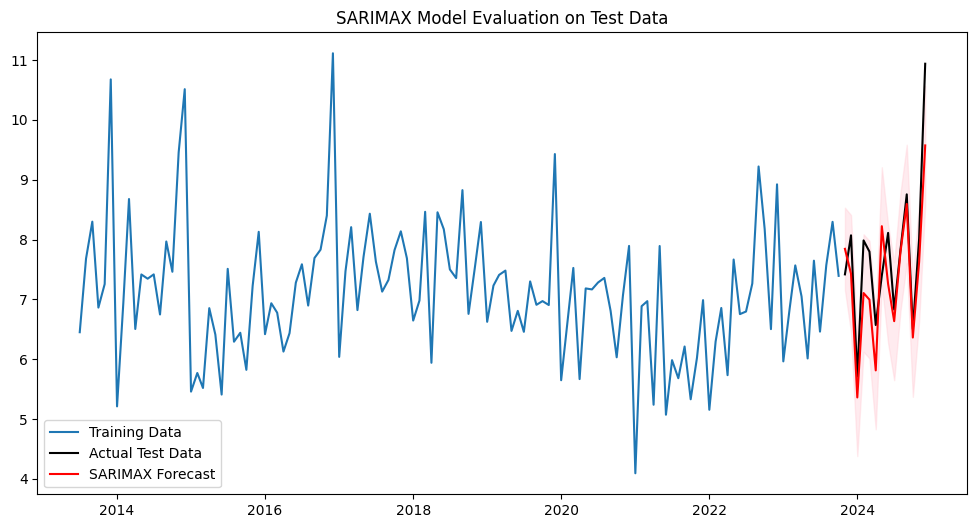

In [63]:
# Forecast for the test period
forecast = results.get_forecast(steps=len(y_test), exog=X_test_scaled)
# Extract forecasted values and confidence intervals
y_pred = forecast.predicted_mean
conf_int = forecast.conf_int()
# Plot actual vs predicted values
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_train, label="Training Data")
plt.plot(y_test, label="Actual Test Data", color="black")
plt.plot(y_pred, label="SARIMAX Forecast", color="red")
plt.fill_between(y_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title("SARIMAX Model Evaluation on Test Data")
plt.show()


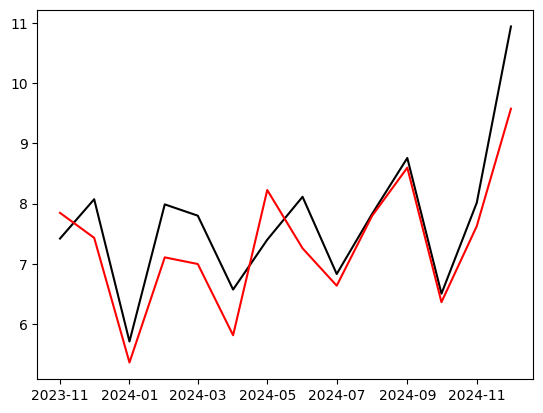

In [64]:
plt.plot(y_test, label="Actual Test Data", color="black")
plt.plot(y_pred, label="SARIMAX Forecast", color="red")


In [65]:
y

,Z-score
Date,
2013-07-01,6.451822
2013-08-01,7.681257
2013-09-01,8.299572
2013-10-01,6.863721
2013-11-01,7.256363
...,...
2024-08-01,7.824952
2024-09-01,8.755918
2024-10-01,6.504123


In [66]:
y_o

,Z-score
Date,
2013-01-01,7.521965
2013-02-01,7.951818
2013-03-01,7.337288
2013-04-01,5.987805
2013-05-01,8.550364
...,...
2024-08-01,7.824952
2024-09-01,8.755918
2024-10-01,6.504123


##Evaluating Model

In [67]:
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
print("Final Model Evaluation:")
print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

Final Model Evaluation:
R² Score: 0.6846
MSE: 0.4439
RMSE: 0.6663
MAE: 0.5582


In [68]:
y

,Z-score
Date,
2013-07-01,6.451822
2013-08-01,7.681257
2013-09-01,8.299572
2013-10-01,6.863721
2013-11-01,7.256363
...,...
2024-08-01,7.824952
2024-09-01,8.755918
2024-10-01,6.504123


In [69]:
x_ls

,Inflow (trade),Outflow (trade),Outflow (non-trade),Reserve position in the IMF,Government’s net domestic assets (million AMD),Banks’ net domestic assets (million AMD),Net other assets (million AMD),CPI,CPI-Services,Economic activity index,...,Transport and communications loans_L6,Trade loans_L6,Service sector loans_L6,Consumer loans loans_L6,Mortgage loans_L6,Others loans_L6,Transport and communications loans (fc)_L6,Mortgage loans (fc)_L6,bitcoin_price_L6,Dolarisation_avg_L6
Date,,,,,,,,,,,,,,,,,,,,,
2013-07-01,0.055216,0.117652,0.151750,2.607223,-0.033031,0.363333,-0.078964,0.432947,7.615600,-0.527096,...,3.164761,-0.359227,7.988320,0.297851,-0.765215,1.671848,6.053955,4.770912,-0.224020,0.689693
2013-08-01,-0.303710,-0.055268,0.070037,2.214388,-0.272461,-0.016521,0.077441,-0.164397,3.772449,-0.334390,...,-0.122457,-0.044775,-0.355318,-0.174659,-0.044132,-0.038100,-0.000210,4.886907,-0.223057,-1.080662
2013-09-01,-0.124450,0.000513,0.205552,-0.405512,-5.134903,0.009153,-0.097571,-0.443371,-0.620376,-0.779097,...,-0.088294,1.049810,-0.393706,1.628013,1.135517,-0.037068,0.126673,5.091539,-0.219689,0.797759
2013-10-01,-0.076063,0.043961,0.179759,-0.064111,3.977887,-0.516475,0.213257,0.424203,-0.815018,-0.126860,...,-0.103149,-0.322251,-0.366425,0.657416,0.332837,-0.174604,-0.169926,5.028400,-0.212087,-0.856525
2013-11-01,0.032212,-0.000210,-0.224735,-0.607541,0.135852,-0.291681,0.220209,0.533535,-0.534184,-0.556743,...,-0.072117,-0.135766,-0.539934,0.259979,-0.015268,-0.159942,0.239039,0.138999,-0.213050,0.756647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,0.905602,3.643783,-0.592764,-0.092694,0.089880,0.301303,-0.401197,0.393789,0.836187,0.125141,...,0.718303,0.096791,0.657915,0.308680,0.417897,-0.121114,-0.078405,-0.828979,3.068450,-0.858411
2024-09-01,-2.333032,-3.961760,-0.472704,-0.280843,-0.251832,2.354862,-0.595043,0.061096,0.934877,0.347495,...,-0.080392,-0.188423,-0.059117,0.648840,0.035822,-0.195711,-0.918006,-1.098799,3.302803,-0.724141
2024-10-01,2.330704,1.515489,0.945213,-0.287311,1.189566,-3.420404,-0.125345,0.092606,-1.063985,0.006552,...,-0.121868,0.948641,0.181233,-0.286787,0.141533,1.239358,-0.478467,-1.210909,1.980467,0.538912


In [70]:
from statsmodels.stats.diagnostic import acorr_ljungbox
ljung_box = acorr_ljungbox(results.resid, lags=[10], return_df=True)
print(ljung_box)

      lb_stat  lb_pvalue
10  12.561233   0.249248


In [71]:
from scipy.stats import jarque_bera
jb_test = jarque_bera(results.resid)
print(f"JB Statistic: {jb_test.statistic}, p-value: {jb_test.pvalue}")

JB Statistic: 1803.366207508481, p-value: 0.0


In [72]:
from statsmodels.stats.diagnostic import het_arch

arch_test = het_arch(results.resid)
print(f"ARCH LM stat: {arch_test[0]}, p-value: {arch_test[1]}")

ARCH LM stat: 42.94217519229852, p-value: 5.092815350629776e-06


In [73]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(results.resid)
print(f"ADF Statistic: {adf_result[0]}, p-value: {adf_result[1]}")

ADF Statistic: -3.5272316855529153, p-value: 0.007314657233399276


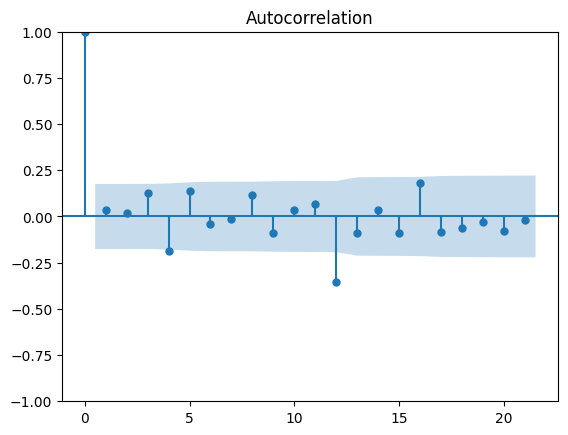

In [74]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(results.resid)
plt.show()

In [75]:
from scipy.stats import shapiro

stat, p = shapiro(results.resid)
print(f"Shapiro-Wilk stat: {stat}, p-value: {p}")

Shapiro-Wilk stat: 0.7905392440361589, p-value: 5.1178228259049535e-12


In [76]:
from scipy.stats import normaltest

stat, p = normaltest(results.resid)
print(f"D'Agostino K^2 stat: {stat}, p-value: {p}")

D'Agostino K^2 stat: 96.09588697479694, p-value: 1.3584488066966406e-21


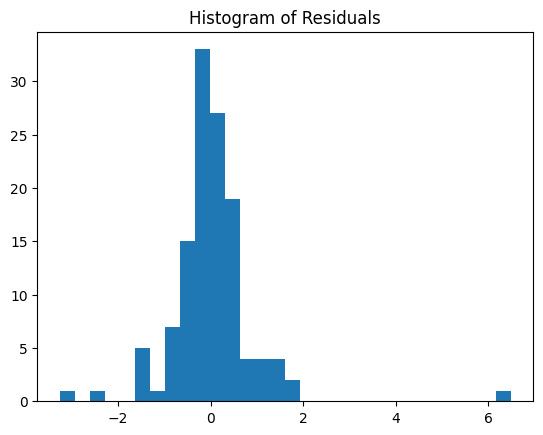

In [77]:
import matplotlib.pyplot as plt

plt.hist(results.resid, bins=30)
plt.title('Histogram of Residuals')
plt.show()

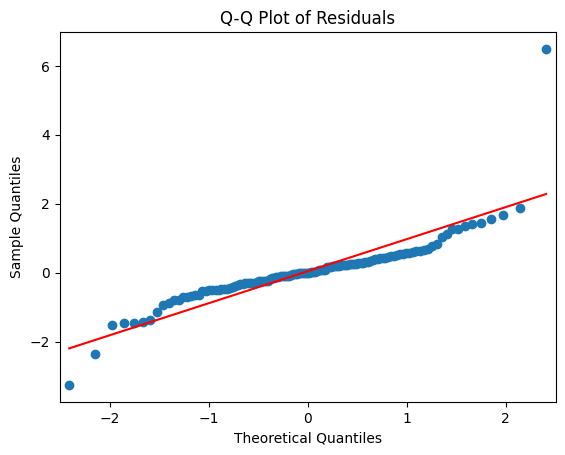

In [78]:
import statsmodels.api as sm

sm.qqplot(results.resid, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

In [79]:
coefficients = results.params
p_values = results.pvalues

# Combining coefficients and p-values into a DataFrame for better display
results_df = pd.DataFrame({
    'Coefficient': coefficients,
    'P-value': p_values
})

print(results_df)

                                                    Coefficient   P-value
Outflow (non-trade)                                    0.111516  0.308168
Banks’ net domestic assets (million AMD)               0.385169  0.000071
Return on capital                                      0.046319  0.582818
High liquidity assets ratio to total assets            0.039060  0.714143
Demand deposits in AMD (million AMD)                   0.250423  0.104501
Foreign currency deposits (million AMD)                0.381609  0.000026
Service sector loans                                   0.172815  0.008761
Consumer loans loans                                   0.228964  0.003995
Mortgage loans                                         0.024711  0.748250
Others loans                                           0.251723  0.006613
Banks’ net domestic assets (million AMD)_L1            0.033297  0.745005
Inv. comp. Repo transactions (million AMD)_L1          0.129167  0.146241
Normative capital ratio to risk-weight

In [80]:
filtered=results_df[results_df['P-value']<=0.05].sort_values(by='Coefficient', ascending=False)

In [81]:
filtered

,Coefficient,P-value
Banks’ net domestic assets (million AMD),0.385169,0.000071
Foreign currency deposits (million AMD),0.381609,0.000026
Others loans,0.251723,0.006613
Consumer loans loans,0.228964,0.003995
Normative capital ratio to risk-weighted assets_L1,0.219471,0.024769
High liquidity assets ratio to total assets_L5,0.192707,0.014557
Service sector loans,0.172815,0.008761
Reserve position in the IMF_L2,-0.236873,0.005319
Inv. comp. Sales and purchase transactions (million AMD)_L6,-0.241605,0.005063


In [82]:
factors=filtered.loc[~filtered.index.isin(['ar.L3', 'sigma2', 'ma.S.L12', 'ar.L2','ma.L2', 'ma.S.L24', 'ma.L1']), 'Coefficient'].index.values

In [83]:
X_train_scaled[factors]

,Banks’ net domestic assets (million AMD),Foreign currency deposits (million AMD),Others loans,Consumer loans loans,Normative capital ratio to risk-weighted assets_L1,High liquidity assets ratio to total assets_L5,Service sector loans,Reserve position in the IMF_L2,Inv. comp. Sales and purchase transactions (million AMD)_L6
Date,,,,,,,,,
2013-07-01,0.527763,0.396812,0.177357,-0.377788,-0.510298,0.582185,-0.530818,0.786473,-0.705127
2013-08-01,0.036036,0.682342,0.128680,-0.183928,0.243359,-0.355744,-0.613960,0.769483,-0.967755
2013-09-01,0.069272,0.817022,-0.139454,0.151131,0.010900,0.181752,-0.637054,2.503911,1.184851
2013-10-01,-0.611161,-0.656361,-0.249805,-0.080739,0.468967,-1.253653,-0.573981,2.123791,0.290942
2013-11-01,-0.320162,-0.657639,-0.086910,0.020330,0.118806,0.743107,-0.830869,-0.411307,-0.549932
...,...,...,...,...,...,...,...,...,...
2023-06-01,2.300036,-0.542536,0.520664,0.075465,-0.021988,0.437908,2.678122,0.250973,-0.600494
2023-07-01,-2.876370,0.047016,0.500553,1.860068,0.790792,-0.420066,0.809342,-0.171397,-0.318027
2023-08-01,-1.398971,0.662077,-2.137524,0.526015,-1.279606,0.887824,-0.127328,-0.306860,0.888226


##re-Evaluating model with meaningful exogenous

In [84]:
import statsmodels.api as sm

# Define SARIMAX Model
p, d, q = (0, 1, 2)  # AR, differencing, MA
P, D, Q, s = (0, 1, 2, 12)  # Seasonal components for monthly data

# Fit SARIMAX on training data
model = sm.tsa.SARIMAX(y_train, exog=X_train_scaled[factors], order=(p, d, q),
                        seasonal_order=(P, D, Q, s),
                        enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()

# Print summary
print(results.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                            Z-score   No. Observations:                  124
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 12)   Log Likelihood                 -78.124
Date:                            Sun, 30 Mar 2025   AIC                            184.247
Time:                                    07:36:59   BIC                            218.279
Sample:                                07-01-2013   HQIC                           197.928
                                     - 10-01-2023                                         
Covariance Type:                              opg                                         
                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Banks’ net domes

In [85]:
import pandas as pd

# Get the table as a string
table = results.summary().tables[1].as_html()

# Convert the HTML table to a DataFrame
summary_df = pd.read_html(table, header=0, index_col=0)[0]
summary_df

<ipython-input-85-15fd3294a625>:7: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  summary_df = pd.read_html(table, header=0, index_col=0)[0]


,coef,std err,z,P>|z|,[0.025,0.975]
Banks’ net domestic assets (million AMD),0.3073,0.072,4.275,0.000,0.166,0.448
Foreign currency deposits (million AMD),0.3557,0.087,4.100,0.000,0.186,0.526
Others loans,0.1575,0.064,2.472,0.013,0.033,0.282
Consumer loans loans,0.0377,0.096,0.394,0.694,-0.150,0.225
Normative capital ratio to risk-weighted assets_L1,0.0860,0.077,1.121,0.262,-0.064,0.236
High liquidity assets ratio to total assets_L5,0.0990,0.091,1.085,0.278,-0.080,0.278
Service sector loans,0.0966,0.081,1.188,0.235,-0.063,0.256
Reserve position in the IMF_L2,-0.0979,0.113,-0.867,0.386,-0.319,0.123
Inv. comp. Sales and purchase transactions (million AMD)_L6,-0.1262,0.072,-1.761,0.078,-0.267,0.014
ma.L1,-0.6769,0.111,-6.101,0.000,-0.894,-0.459


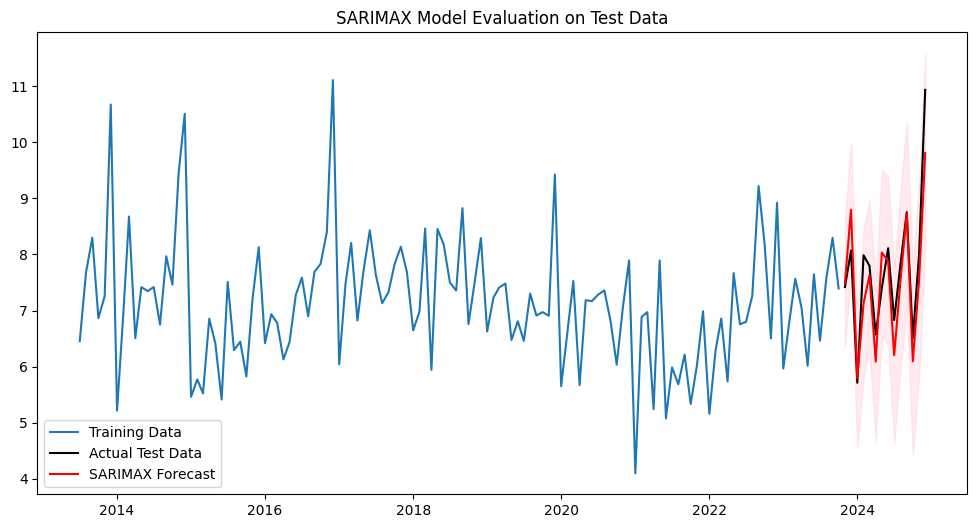

In [86]:
# Forecast for the test period
forecast = results.get_forecast(steps=len(y_test), exog=X_test_scaled[factors])
# Extract forecasted values and confidence intervals
y_pred = forecast.predicted_mean
conf_int = forecast.conf_int()
# Plot actual vs predicted values
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_train, label="Training Data")
plt.plot(y_test, label="Actual Test Data", color="black")
plt.plot(y_pred, label="SARIMAX Forecast", color="red")
plt.fill_between(y_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title("SARIMAX Model Evaluation on Test Data")
plt.show()


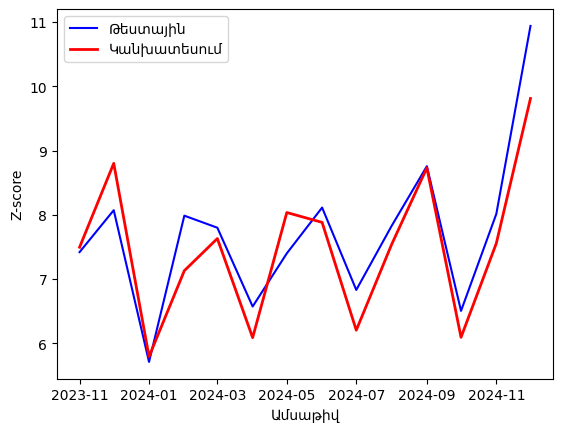

In [87]:
# plt.plot(y_test, label="Actual Test Data", color="black")
# plt.plot(y_pred, label="SARIMAX Forecast", color="red")

plt.plot(y_test, color='blue', label='Թեստային')
plt.plot(y_pred, color='red', linewidth=2, label='Կանխատեսում')
plt.xlabel('Ամսաթիվ')
plt.ylabel('Z-score')
#plt.title('ARIMA')
plt.legend()
plt.show()

In [88]:
# R² Score: 0.5698
# MSE: 0.6055
# RMSE: 0.7782
# MAE: 0.6347

In [89]:
from statsmodels.stats.diagnostic import acorr_ljungbox
ljung_box = acorr_ljungbox(results.resid, lags=[10], return_df=True)
lb_pvalue=ljung_box['lb_pvalue'].values[0].round(4)
lb_pvalue
print(ljung_box)

     lb_stat  lb_pvalue
10  9.220856    0.51128


In [90]:
from scipy.stats import jarque_bera
jb_test = jarque_bera(results.resid)
print(f"JB Statistic: {jb_test.statistic}, p-value: {jb_test.pvalue}")

JB Statistic: 292.646085263606, p-value: 2.836024704917806e-64


In [91]:
from statsmodels.stats.diagnostic import het_arch

arch_test = het_arch(results.resid)
print(f"ARCH LM stat: {arch_test[0]}, p-value: {arch_test[1]}")

ARCH LM stat: 81.21779301069883, p-value: 2.896447979280336e-13


In [92]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(results.resid)
print(f"ADF Statistic: {adf_result[0]}, p-value: {adf_result[1]}")

ADF Statistic: -13.959845440334812, p-value: 4.540863818408626e-26


In [93]:
from scipy.stats import shapiro
from scipy.stats import shapiro
# A p-value > 0.05 indicates that the residuals do not significantly deviate from normality
stat, shap_p_value = shapiro(results.resid)
print(f"Shapiro-Wilk stat: {stat}, p-value: {shap_p_value}")

Shapiro-Wilk stat: 0.8929892319033697, p-value: 5.9238382208741066e-08


In [94]:
from scipy.stats import normaltest

stat, p = normaltest(results.resid)
print(f"D'Agostino K^2 stat: {stat}, p-value: {p}")

D'Agostino K^2 stat: 32.04507986925547, p-value: 1.1002701233401042e-07


In [95]:
df=pd.DataFrame({'Test':[], 'P-value':[]})
adf={'Test':'ADF Test','P-value' :adf_result[1]}
arch={ 'Test':'arch_test','P-value' :arch_test[1]}
shap={ 'Test':'Shapiro','P-value' :shap_p_value}
lb={'Test':'Ljung-Box','P-value' :lb_pvalue}
df = pd.concat([df, pd.DataFrame([adf])], ignore_index=True)
df=pd.concat([df, pd.DataFrame([arch])], ignore_index=True)
df = pd.concat([df, pd.DataFrame([shap])], ignore_index=True)
df = pd.concat([df, pd.DataFrame([lb])], ignore_index=True)

In [96]:
df

,Test,P-value
0,ADF Test,4.540864e-26
1,arch_test,2.896448e-13
2,Shapiro,5.923838e-08
3,Ljung-Box,5.113000e-01


In [97]:
df['P-value']=df['P-value'].apply(lambda x: format(x, 'f'))

In [98]:
df

,Test,P-value
0,ADF Test,0.000000
1,arch_test,0.000000
2,Shapiro,0.000000
3,Ljung-Box,0.511300


In [99]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)
print('Forecast Accuracy Metrics:')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
# Interpretation:

Forecast Accuracy Metrics:
MAE: 0.4429352559836711
MSE: 0.29468531035512796
RMSE: 0.5428492519614704
MAPE: 0.05621042235180702


In [100]:
from sklearn.metrics import r2_score

final_r2 = r2_score(y_test, y_pred)
print(f"Final Model R² Score: {final_r2:.4f}")

Final Model R² Score: 0.7906


In [101]:
len(y_pred)

14